In [1]:
from IPython.display import display, clear_output
from bin.config import *
from bin.consumer import Consumer

In [2]:
spark_session: SparkSession = (
    SparkSession.builder.appName("Real-time Evaluation Prediction")
    .config("spark.jars.packages", ",".join(SPARK_PACKAGES))
    .getOrCreate()
)

In [3]:
capture_con: Consumer = Consumer(
    CAPTURE_TOPIC, CAPTURE_SCHEMA_LIST, spark_session
)

prediction_con: Consumer = Consumer(
    PREDICTION_TOPIC, PREDICTION_SCHEMA_LIST, spark_session
)

In [4]:
capture_df: DataFrame = capture_con.get_history_df()
prediction_df: DataFrame = prediction_con.get_history_df()

prediction_df = (
    prediction_df.withColumn("range_history", F.col("max_history_ds") - F.col("min_history_ds"))
    .withColumn("future_forecasting", F.col("Timestamp") - F.col("max_history_ds"))
)

In [11]:
join_df = (
    capture_df.join(
        prediction_df,
        on=["SegmentID", "Timestamp", "Direction"],
        how="inner"
    )
    .withColumns({
        "AE": F.abs(F.col("Vol") - F.col("prediction_vol")),
        "APE": F.col("AE") / F.col("Vol"),
        "range_days": F.expr("cast(range_history as int) / 60 / 60 / 24"),
        "future_forecasting_minutes": F.expr("cast(future_forecasting as int) / 60"),
    }).drop("prediction_ds").distinct()
)

In [12]:
result_df = (
    join_df.filter(F.col("range_days").isin(1, 3, 7)).groupBy(
        "range_days", "future_forecasting_minutes"
    ).agg(
        F.mean("AE").alias("MAE"),
        F.mean("APE").alias("MAPE")
    ).orderBy("range_days", "future_forecasting_minutes")
)

In [13]:
try:
    while True:
        display(result_df.show(truncate=False))
        sleep(DELAY)
        clear_output(wait=False)
except KeyboardInterrupt:
    print("Stopping live...")

+----------+--------------------------+------------------+------------------+
|range_days|future_forecasting_minutes|MAE               |MAPE              |
+----------+--------------------------+------------------+------------------+
|1.0       |15.0                      |65.14403726903645 |2.698376070117741 |
|1.0       |30.0                      |68.7648693422478  |3.055176302980304 |
|1.0       |45.0                      |72.68375343306488 |3.180608756824797 |
|1.0       |60.0                      |73.43790958305358 |3.4704070728444614|
|3.0       |15.0                      |37.48757694544656 |2.628695766301816 |
|3.0       |30.0                      |38.22349815775478 |1.541917254841239 |
|3.0       |45.0                      |39.706139128599986|2.0659343933151675|
|3.0       |60.0                      |40.346620025155254|2.043624796533942 |
|7.0       |15.0                      |39.4402499563356  |0.9199849081298122|
|7.0       |30.0                      |39.732055013241045|0.8093

None

Stopping live...


In [14]:
result_pdf = result_df.toPandas()

In [83]:
result_pdf

,range_days,future_forecasting_minutes,MAE,MAPE
0,1,15,65.144037,2.698376
1,1,30,68.764869,3.055176
2,1,45,72.683753,3.180609
3,1,60,73.437910,3.470407
4,3,15,37.487577,2.628696
5,3,30,38.223498,1.541917
6,3,45,39.706139,2.065934
7,3,60,40.346620,2.043625
8,7,15,39.440250,0.919985
9,7,30,39.732055,0.809374


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
plt.rcParams['font.family'] = 'Bahnschrift'  # Change 'your_font_family' to the desired font family


result_pdf["future_forecasting_minutes"] = result_pdf["future_forecasting_minutes"].astype('int')
result_pdf["range_days"] = result_pdf["range_days"].astype('int')

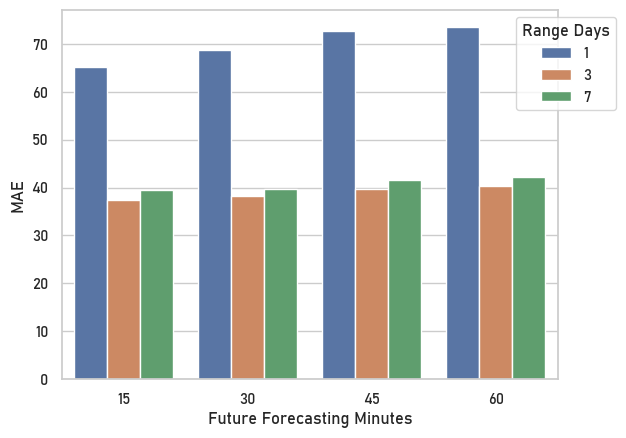

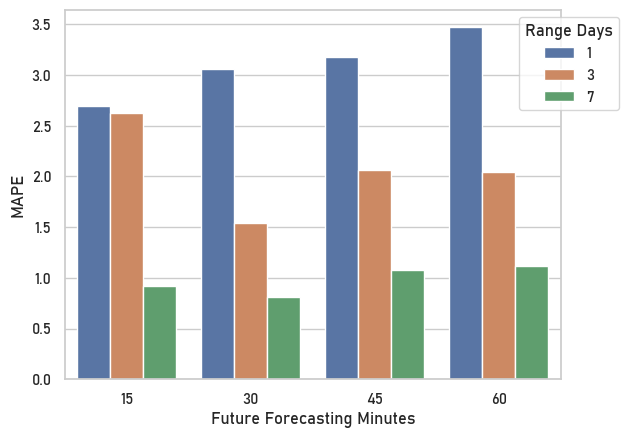

In [84]:
sns.barplot(data=result_pdf, x="future_forecasting_minutes", y="MAE", hue="range_days")
plt.legend(title="Range Days", bbox_to_anchor=(0.9, 1), loc='upper left')
plt.xlabel("Future Forecasting Minutes")
plt.show()

sns.barplot(data=result_pdf, x="future_forecasting_minutes", y="MAPE", hue="range_days")
plt.legend(title="Range Days", bbox_to_anchor=(0.9, 1), loc='upper left')
plt.xlabel("Future Forecasting Minutes")
plt.show()

